In [120]:
import numpy as np
import pandas as pd
from datetime import datetime
from meza import io, process as pr, convert as cv
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import signal
import seaborn as sns
from io import open
import itertools as it
import matplotlib.pyplot as plt


# Read data

Read database access

In [ ]:
records = io.read('/home/ariviere/Documents/Bassin_Seine/Temperature/Temperature_data/Temper_Data_2020.mdb')


# Read Seine data
delete columns Origine Site

In [135]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
temp_seine = pd.read_csv('/home/ariviere/Documents/Bassin_Seine/Temperature/Temperature_data/TJ_SEINE-PARIS_2020.csv',sep=';')

temp_seine=temp_seine.drop(columns=['Origine', 'Site'])
temp_seine['loc']='Seine'
temp_seine.head()
pd.to_datetime(temp_seine['Date'])

0       1893-11-06
1       1893-12-06
2       1893-06-13
3       1893-06-14
4       1893-06-15
           ...    
22009   2019-12-27
22010   2019-12-28
22011   2019-12-29
22012   2019-12-30
22013   2019-12-31
Name: Date, Length: 22014, dtype: datetime64[ns]

# Read Air data
keep only Orly

In [ ]:
temp_air = pd.read_csv('/home/ariviere/Documents/Bassin_Seine/Temperature/Temperature_data/Temp_Air.csv',sep=',', index_col=0, parse_dates=True)
temp_air=temp_air.drop(columns=['Tory','Monsouris','Argenteuil','Issou'])
temp_air['loc']='Air'
temp_air['Temp']=temp_air['Orly']
#temp_air=temp_air.rename(columns={"Date": "Date", "Orly": "Temp","loc":"loc"})
temp_air.head()

Add columns with year and month

In [ ]:
data=(temp_air,temp_seine)
for i in data:
    i['Year'] = i.index.year
    i['Month'] = i.index.month
    i['year_month'] = pd.to_datetime(i.index)

In [17]:
temp_air.head()

,Orly,loc,Temp,Year,Month,year_month
Date,,,,,,
1990-01-01,-0.90,Air,-0.90,1990,1,1990-01-01
1990-02-01,0.35,Air,0.35,1990,2,1990-02-01
1990-03-01,0.25,Air,0.25,1990,3,1990-03-01
1990-04-01,1.00,Air,1.00,1990,4,1990-04-01
1990-05-01,1.70,Air,1.70,1990,5,1990-05-01


In [20]:
temp_seine.head()

,Temp,loc,Year,Month,year_month
Date,,,,,
1893-11-06,18.9,Seine,1893,11,1893-11-06
1893-12-06,19.0,Seine,1893,12,1893-12-06
1893-06-13,19.6,Seine,1893,6,1893-06-13
1893-06-14,20.6,Seine,1893,6,1893-06-14
1893-06-15,20.7,Seine,1893,6,1893-06-15


# Use seaborn style defaults and set the default figure size

In [23]:
df = pd.concat([temp_seine,temp_air],axis=0)
df.head()

,Temp,loc,Year,Month,year_month,Orly
Date,,,,,,
1893-11-06,18.9,Seine,1893,11,1893-11-06,NaN
1893-12-06,19.0,Seine,1893,12,1893-12-06,NaN
1893-06-13,19.6,Seine,1893,6,1893-06-13,NaN
1893-06-14,20.6,Seine,1893,6,1893-06-14,NaN
1893-06-15,20.7,Seine,1893,6,1893-06-15,NaN


# plot all data

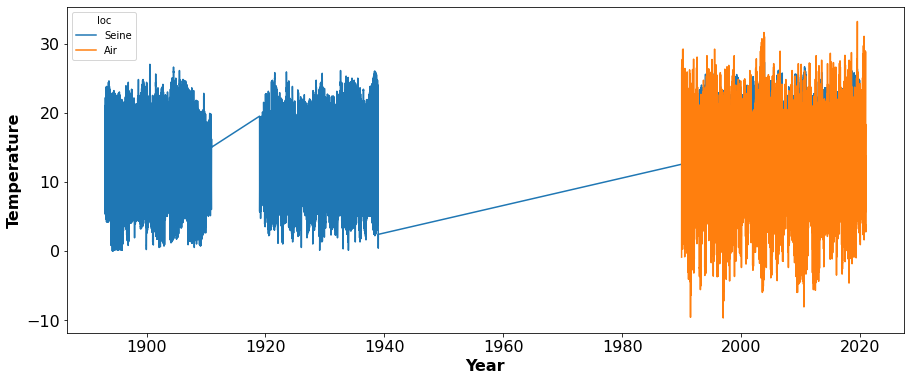

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=df,x='year_month',y='Temp',hue="loc" )
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Temperature', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

In [ ]:
temp_seine.plot(x='year_month', y='Temp', figsize=(19,4))

# Seasonality

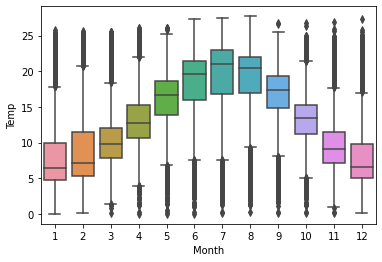

In [53]:
sns.boxplot(data=temp_seine, x='Month', y='Temp');

In [ ]:
sns.boxplot(data=temp_air, x='Month', y='Orly');

# Time Series Components

In [111]:
df_seine=temp_seine
df_seine['Date']=pd.to_datetime(df_seine['Date'])
df_seine=df_seine.set_index('Date')
df_seine=df_seine.drop(columns=['loc','Year','Month','year_month','level_0','index'])

df_seine.index
df_seine=df_seine['Temp']
df_seine.isnull().value_counts()
df_seine = df_seine.ffill()


df_seine.head()

Date
1893-11-06    18.9
1893-12-06    19.0
1893-06-13    19.6
1893-06-14    20.6
1893-06-15    20.7
Name: Temp, dtype: float64

In [112]:
temp_seine.head()

,level_0,index,Date,Temp,loc,Year,Month,year_month
0,0,0,1893-11-06,18.9,Seine,1893,11,1893-11-06
1,1,1,1893-12-06,19.0,Seine,1893,12,1893-12-06
2,2,2,1893-06-13,19.6,Seine,1893,6,1893-06-13
3,3,3,1893-06-14,20.6,Seine,1893,6,1893-06-14
4,4,4,1893-06-15,20.7,Seine,1893,6,1893-06-15
